In [197]:
import json
import numpy as np
import pandas as pd
# from src import *

In [198]:
# Set path to data
path = '../data/raw/CDSA_2024-02-29-12-30-14.xlsx'

# Import data
cdsa = pd.read_excel(path, sheet_name='CDSA')
labs = pd.read_excel(path, sheet_name='repeat2')
cnss = pd.read_excel(path, sheet_name='repeat1_001')
cvss = pd.read_excel(path, sheet_name='repeat1_002')
urss = pd.read_excel(path, sheet_name='repeat1_003')
lrss = pd.read_excel(path, sheet_name='repeat1_004')
gits = pd.read_excel(path, sheet_name='repeat1_005')
guss = pd.read_excel(path, sheet_name='repeat1_006')
msss = pd.read_excel(path, sheet_name='repeat1_007')
skns = pd.read_excel(path, sheet_name='repeat1_008')
spss = pd.read_excel(path, sheet_name='repeat1_009')
oths = pd.read_excel(path, sheet_name='repeat1_010')

# Import columns from json file
with open('../data/dictionaries/columns.json') as f:
    columns, multiple_entry_cols, diagnosis = json.load(f).values()

In [199]:
for k, v in columns.items():
    if k in multiple_entry_cols:
        multiple_entry_cols[v] = multiple_entry_cols.pop(k)

In [200]:
def select_columns(df: pd.DataFrame,
                          columns: dict,
                          rename: bool = True) -> pd.DataFrame:
    """
    Filter columns of a dataframe based on the keys of a dictionary.
    """
    df_ = df[df.columns.intersection(columns.keys())]
    if rename:
        df_ = df_.rename(columns=columns)
    return df_

cdsa_ = select_columns(cdsa, columns)
labs_ = select_columns(labs, columns)
cnss_ = select_columns(cnss, columns)
cvss_ = select_columns(cvss, columns)
urss_ = select_columns(urss, columns)
lrss_ = select_columns(lrss, columns)
gits_ = select_columns(gits, columns)
guss_ = select_columns(guss, columns)
msss_ = select_columns(msss, columns)
skns_ = select_columns(skns, columns)
spss_ = select_columns(spss, columns)
oths_ = select_columns(oths, columns)

In [201]:
# Merge dataframes
ss = pd.merge(cnss_, cvss_, on=cnss_.columns.intersection(cvss_.columns).tolist(), how='outer')
ss = pd.merge(ss, urss_, on=ss.columns.intersection(urss_.columns).tolist(), how='outer')
ss = pd.merge(ss, lrss_, on=ss.columns.intersection(lrss_.columns).tolist(), how='outer')
ss = pd.merge(ss, gits_, on=ss.columns.intersection(gits_.columns).tolist(), how='outer')
ss = pd.merge(ss, guss_, on=ss.columns.intersection(guss_.columns).tolist(), how='outer')
ss = pd.merge(ss, msss_, on=ss.columns.intersection(msss_.columns).tolist(), how='outer')
ss = pd.merge(ss, skns_, on=ss.columns.intersection(skns_.columns).tolist(), how='outer')
ss = pd.merge(ss, spss_, on=ss.columns.intersection(spss_.columns).tolist(), how='outer')
ss = pd.merge(ss, oths_, on=ss.columns.intersection(oths_.columns).tolist(), how='outer')
ss = pd.merge(ss, labs_, on=ss.columns.intersection(labs_.columns).tolist(), how='outer')
df = pd.merge(cdsa_, ss, on=cdsa_.columns.intersection(ss.columns).tolist(), how='outer')

df.drop_duplicates(ignore_index=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16929 entries, 0 to 16928
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   county             3372 non-null   object 
 1   patient_id         3930 non-null   object 
 2   age                3927 non-null   float64
 3   sex                3907 non-null   object 
 4   temperature        3077 non-null   float64
 5   triage_            329 non-null    object 
 6   blood_pressure     1072 non-null   object 
 7   weight             3052 non-null   float64
 8   failure_to_thrive  1292 non-null   object 
 9   height             2601 non-null   float64
 10  stunting           1077 non-null   object 
 11  spo2               2002 non-null   float64
 12  chills             2905 non-null   object 
 13  muac               985 non-null    object 
 14  gen_signs          573 non-null    object 
 15  lab_investigation  3925 non-null   object 
 16  diagnosis          426

In [202]:
def split_cells(df: pd.DataFrame,
                column: str,
                uv: list = None,
                sep: str = "&") -> pd.DataFrame:
    """
    Split the cells of a column into multiple rows
    """
    if uv is None:
        df.rename(columns={column: "col"}, inplace=True)
        df = df.assign(col=df["col"].str.split(sep)).explode("col").reset_index(drop=True)
        df.rename(columns={"col": column}, inplace=True)
    else:
        if not isinstance(uv, list):
            uv = list(uv)
        for i in uv:
            df[column] = df[column].str.replace(i, sep + i + sep)
        df[column] = df[column].str.replace(sep + r"\s+", sep, regex=True)
        df[column] = df[column].str.replace(sep + r"$", "", regex=True)
        df[column] = df[column].str.replace(r"^" + sep, "", regex=True)
        df[column] = df[column].str.replace(sep + sep, sep)

        df.rename(columns={column: "col"}, inplace=True)
        df = df.assign(col=df["col"].str.split(sep)).explode("col").reset_index(drop=True)
        df.rename(columns={"col": column}, inplace=True)

        df[column] = df[column].str.strip()

    return df

# Split cells
for k, v in multiple_entry_cols.items():
    df = split_cells(df, k, v)
    
# Drop duplicates in every column except duration
df.drop_duplicates(subset=df.columns.difference(["duration"]), inplace=True)

# Repopulate the cdsa columns
for col in df.columns.intersection(cdsa_.columns):
    df[col] = df.groupby("_uuid")[col].transform("first")

In [203]:
# Construct triage_signs
df["fever"] = np.where(df["temperature"] > 37.5, "Fever", np.nan)
df["failure_to_thrive"] = np.where(df["failure_to_thrive"] == "Yes", "Failure to thrive", np.nan)
df["stunting"] = np.where(df["stunting"] == "Yes", "Stunting", np.nan)
df["chills"] = np.where(df["chills"] == "Yes", "Chills", np.nan)

triage_cols = ["triage_", "fever", "failure_to_thrive", "stunting", "chills"]

df = pd.melt(df, id_vars=[i for i in df.columns if i not in triage_cols],
             value_vars=triage_cols, var_name="trg", value_name="trg_signs").drop("trg", axis=1).drop_duplicates()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40685 entries, 0 to 85979
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   county             35647 non-null  object 
 1   patient_id         40625 non-null  object 
 2   age                40604 non-null  float64
 3   sex                40331 non-null  object 
 4   temperature        32104 non-null  float64
 5   blood_pressure     12876 non-null  object 
 6   weight             32122 non-null  float64
 7   height             27867 non-null  float64
 8   spo2               20774 non-null  float64
 9   muac               10117 non-null  object 
 10  gen_signs          7858 non-null   object 
 11  lab_investigation  40568 non-null  object 
 12  diagnosis          40240 non-null  object 
 13  _uuid              40685 non-null  object 
 14  index              40685 non-null  int64  
 15  cns_signs          3714 non-null   object 
 16  duration           21565 no

In [204]:
# Convert all the object values to lowercase and remove leading and trailing whitespaces
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].str.replace(r"\s+", " ", regex=True)
    df[col] = df[col].str.lower().str.strip()

In [205]:
df["diagnosis"] = df["diagnosis"].str.replace(r"\d+", "", regex=True)
df["diagnosis"] = df["diagnosis"].str.replace("/", " andor ")
df["diagnosis"] = df["diagnosis"].str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)
df["diagnosis"] = df["diagnosis"].str.replace(" andor ", "/", regex=True)

# Correct misspelled words
df["diagnosis"] = df["diagnosis"].str.replace("diarrhea", "diarrhoea")
df["diagnosis"] = df["diagnosis"].str.replace("g e", "gastroenteritis")
df["diagnosis"] = df["diagnosis"].str.replace("tuber culosis", "tuberculosis")
df["diagnosis"] = df["diagnosis"].str.replace("tb", "tuberculosis")
df["diagnosis"] = df["diagnosis"].str.replace("s malaria", "malaria")
df["diagnosis"] = df["diagnosis"].str.replace("pmeumonia", "pneumonia")
df["diagnosis"] = df["diagnosis"].str.replace("urti", "uti")
df["diagnosis"] = df["diagnosis"].str.replace("anaemiasickle cell", "sickle cell")
df["diagnosis"] = df["diagnosis"].str.replace("extra pulmonary", "extrapulmonary")
df["diagnosis"] = df["diagnosis"].str.replace("malnourished", "malnutrition")
df["diagnosis"] = df["diagnosis"].str.replace(r"\bty\b", "typhoid", regex=True)
df["diagnosis"] = df["diagnosis"].str.replace(r"\btyphoi\b", "typhoid", regex=True)
df["diagnosis"] = df["diagnosis"].str.replace("complicated", "severe")
df["diagnosis"] = df["diagnosis"].str.replace(r"\bty\b", "typhoid", regex=True)
df["diagnosis"] = df["diagnosis"].str.replace(r"\bmenegititis\b", "meningitis", regex=True)

df["diagnosis"] = df["diagnosis"].str.replace(r"\s+", " ", regex=True)
df["diagnosis"] = df["diagnosis"].str.strip()

df["diagnosis"] = df["diagnosis"].str.replace("cough cold", "cough/cold")
df["diagnosis"] = df["diagnosis"].str.replace("cough and cold", "cough/cold")
df["diagnosis"] = df["diagnosis"].str.replace("pneuonitis", "pneumonitis")
df["diagnosis"] = df["diagnosis"].str.replace("no pneumonia", "")
df["diagnosis"] = df["diagnosis"].str.replace("no ova and cyst", "")

In [206]:
df = split_cells(df, "diagnosis", diagnosis)

# If a value is not in the diagnosis list, replace it with NaN
df["diagnosis"] = df["diagnosis"].where(df["diagnosis"].isin(diagnosis), np.nan)

In [207]:
symptoms = ['trg_signs', 'gen_signs', 'cns_signs', 'cvs_signs', 'urs_signs', 'lrs_signs', 'git_signs', 'gus_signs', 'mss_signs', 'skn_signs', 'sps_signs', 'oth_signs']

df = pd.melt(df, id_vars=[i for i in df.columns if i not in symptoms],
             value_vars=symptoms, var_name="system", value_name="symptoms").drop_duplicates()

In [208]:
df.replace({"nan": np.NaN, "None": np.NaN, None:np.NaN}, inplace=True)
df['system'] = df['system'].str.replace('_signs', '')
df['patient_id'] = df['patient_id'].str.replace(' ', '')
df['patient_id'] = np.where(df['patient_id'].str.replace('/', '').str.isnumeric(), df['patient_id'], np.NAN)
df['age'] = np.where(df['age'] < 100, df['age'], np.NAN)
df['height'] = np.where(df['height'] < 300, df['height'], np.NAN)
df['weight'] = np.where(df['weight'] > 0, df['weight'], np.NAN)
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df['bmi'] = np.where((df['bmi'] > 0) & (df['bmi'] < 100), df['bmi'], np.NAN)
df['temperature'] = np.where(df['temperature'] > 10, df['temperature'], np.NAN)
df['spo2'] = np.where(df['spo2'] < 100, df['spo2'], np.NAN)
df['bp_systolic'] = df['blood_pressure'].str.split('/').str[0]
df['bp_systolic'] = pd.to_numeric(df['bp_systolic'], errors='coerce')
df['bp_systolic'] = np.where((df['bp_systolic'] >= 70) & (df['bp_systolic'] <= 190), df['bp_systolic'], np.NAN)
df['bp_diastolic'] = df['blood_pressure'].str.split('/').str[1]
df['bp_diastolic'] = pd.to_numeric(df['bp_diastolic'], errors='coerce')
df['bp_diastolic'] = np.where((df['bp_diastolic'] >= 40) & (df['bp_diastolic'] <= 100), df['bp_diastolic'], np.NAN)
df['duration'] = np.where((df['duration'] > 0) & (df['duration'] < 367), df['duration'], np.NAN)
df.loc[df.symptoms.isna(), "duration"] = np.NaN
df = df.replace('undefined', np.NAN)
df = df.map(lambda x: x.lower().strip() if isinstance(x, str) else x)
# df.loc[df.symptoms.isna(), "system"] = np.NaN
# df.loc[df.lab_test.isna(), "lab_investigation"] = "no"
df.loc[df.bp_diastolic.isna(), "bp_systolic"] = np.NaN
df.loc[df.bp_systolic.isna(), "bp_diastolic"] = np.NaN
df.drop_duplicates(inplace=True)

df = df[['_uuid', 'patient_id', 'county', 'age', 'sex', 'height', 'weight', 'bmi', 'temperature', 'bp_systolic', 'bp_diastolic', 'spo2', 'muac', 'symptoms', 'duration', 'system', 'lab_investigation', 'lab_test', 'diagnosis']].reset_index(drop=True)

# Validate data types
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].astype("category")
    if df[col].dtype == "float64":
        if df[col].apply(float.is_integer).all():
            df[col] = df[col].astype("Int64")

df.to_csv('../data/interim/cdsa.csv', index=False)

display(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173645 entries, 0 to 173644
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   _uuid              173645 non-null  category
 1   patient_id         159393 non-null  category
 2   county             148269 non-null  category
 3   age                172990 non-null  float64 
 4   sex                172215 non-null  category
 5   height             116796 non-null  float64 
 6   weight             137151 non-null  float64 
 7   bmi                115559 non-null  float64 
 8   temperature        136081 non-null  float64 
 9   bp_systolic        49769 non-null   float64 
 10  bp_diastolic       49769 non-null   float64 
 11  spo2               79506 non-null   float64 
 12  muac               37580 non-null   category
 13  symptoms           20078 non-null   category
 14  duration           12833 non-null   float64 
 15  system             173645 non-null

None

,_uuid,patient_id,county,age,sex,height,weight,bmi,temperature,bp_systolic,bp_diastolic,spo2,muac,symptoms,duration,system,lab_investigation,lab_test,diagnosis
0,2db2bd9b-7aea-4713-8b87-2aed40670629,564378/21,kisumu,26.0,male,168.0,66.0,23.384354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trg,yes,haemogramm,NaN
1,2db2bd9b-7aea-4713-8b87-2aed40670629,564378/21,kisumu,26.0,male,168.0,66.0,23.384354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trg,yes,x-ray,NaN
2,9f6310c4-aaf3-4752-874a-e09f1ac6f0cd,366903/2021,kilifi,81.0,female,NaN,NaN,NaN,36.7,103.0,68.0,98.0,NaN,NaN,NaN,trg,yes,pcr,NaN
3,e07aea58-59c0-42b8-bd28-79858401435a,584733/21,kisumu,22.0,female,161.5,86.0,32.972615,35.9,NaN,NaN,NaN,NaN,NaN,NaN,trg,yes,sat,NaN
4,0ae5856a-e684-4dcb-85b5-515c86f20fde,535169/20,kisumu,25.0,male,162.0,60.0,22.862369,36.4,125.0,78.0,NaN,NaN,NaN,NaN,trg,yes,stool examination,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173640,ffe78335-d242-4d4f-832a-0e8ed6767b88,246/23,kisumu,1.0,female,78.0,9.9,16.272189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,oth,yes,NaN,tuberculosis
173641,ffea0f90-ed7c-44a4-a5a5-053273a0589a,383614/19,kisumu,1.0,female,NaN,10.0,NaN,36.9,NaN,NaN,NaN,NaN,NaN,NaN,oth,yes,NaN,pneumonia
173642,ffea0f90-ed7c-44a4-a5a5-053273a0589a,383614/19,kisumu,1.0,female,NaN,10.0,NaN,36.9,NaN,NaN,NaN,NaN,NaN,NaN,oth,yes,NaN,pneumonia
173643,ffef31f9-f929-46cf-9e69-cb209a7fdea0,647920/22,kisumu,4.0,male,100.8,15.0,14.762850,37.8,NaN,NaN,NaN,NaN,NaN,NaN,oth,yes,NaN,NaN


### Target variable: Diagnosis
The target variable is `diagnosis`. It is a categorical variable with 29 unique values. The top five diagnoses are malaria (795), pneumonia (789), covid (561), malnutrition (446), and diarrhoea (345). The top five diagnoses account for 86.05% of the data. Like we had imagined, class imbalance is a problem in this dataset. We will have to address this issue when we start building models.

,diagnosis,count
0,malaria,880
1,pneumonia,795
2,covid,573
3,malnutrition,454
4,diarrhoea,358
5,tuberculosis,282
6,gastroenteritis,160
7,cough/cold,18
8,uti,7
9,sickle cell,4


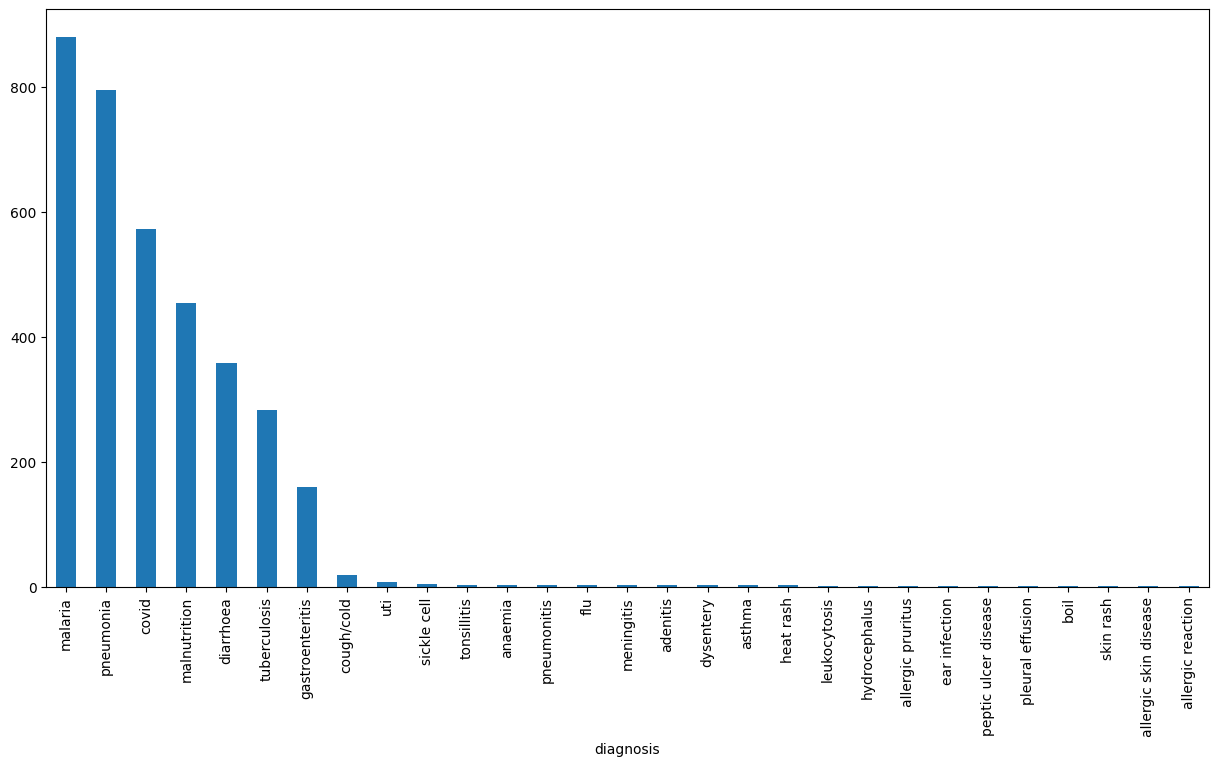

In [209]:
diagnosis_by_id = df[["_uuid", "diagnosis"]].drop_duplicates()
diagnosis_by_id.diagnosis.value_counts().plot(kind="bar", figsize=(15, 7.5))
dd = diagnosis_by_id.diagnosis.value_counts().reset_index()
dd

,sex,count
0,male,1966
1,female,1908


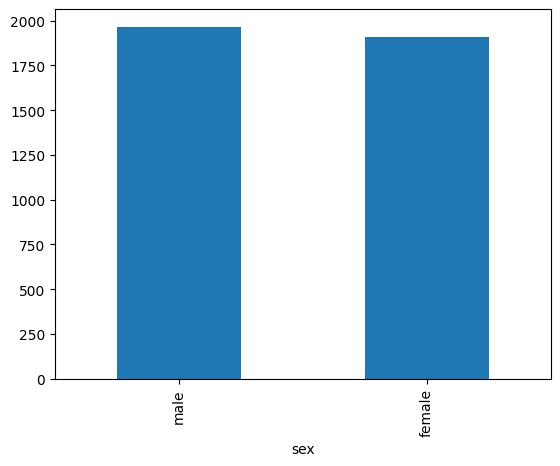

In [210]:
sex_by_id = df[["_uuid", "sex"]].drop_duplicates()
sex_by_id.sex.value_counts().plot(kind="bar")
sex_by_id.sex.value_counts().reset_index()

,muac,count
0,green,400
1,red,388
2,yellow,194


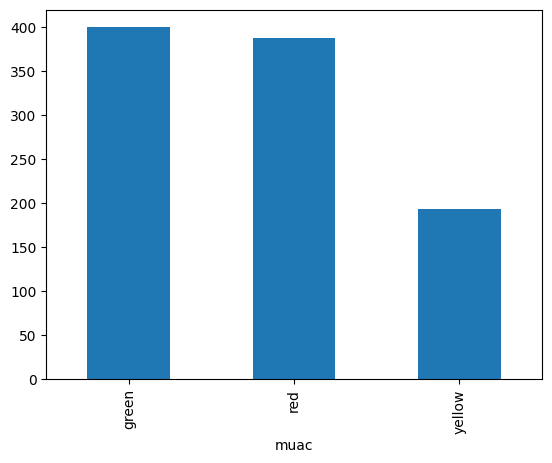

In [211]:
muac_by_id = df[["_uuid", "muac"]].drop_duplicates()
muac_by_id.muac.value_counts().plot(kind="bar")
muac_by_id.muac.value_counts().reset_index()

,lab_investigation,count
0,yes,2802
1,no,1090


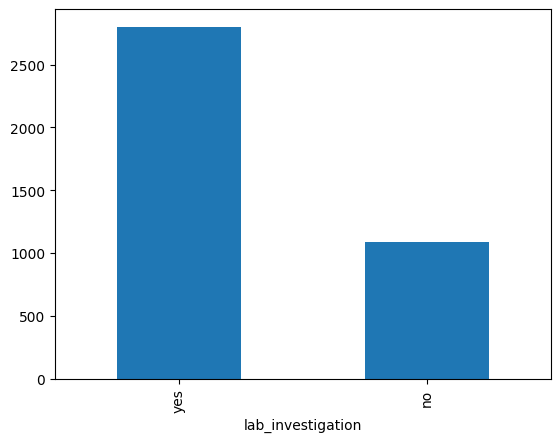

In [212]:
lab_investigation_by_id = df[["_uuid", "lab_investigation"]].drop_duplicates()
lab_investigation_by_id.lab_investigation.value_counts().plot(kind="bar")
lab_investigation_by_id.lab_investigation.value_counts().reset_index()

,lab_test,count
0,microscopy,828
1,x-ray,541
2,sat,410
3,covid-rdt,338
4,stool examination,316
5,mrdt,216
6,pcr,210
7,genexpert,161
8,haemogramm,150
9,culture,6


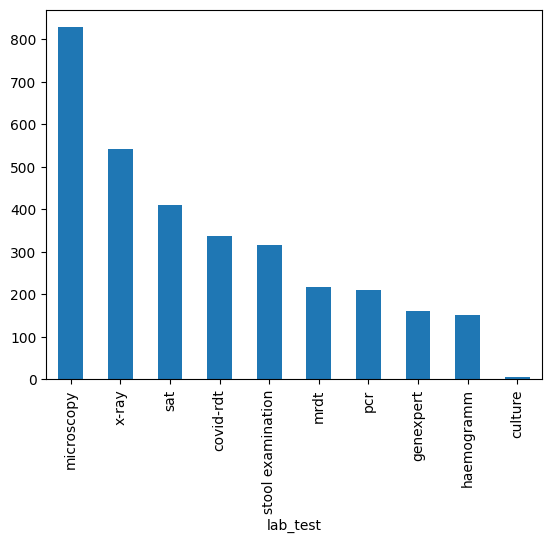

In [213]:
lab_test_by_id = df[["_uuid", "lab_test"]].drop_duplicates()
lab_test_by_id.lab_test.value_counts().plot(kind="bar")
lab_test_by_id.lab_test.value_counts().reset_index()

,symptoms,count
0,headache,979
1,loose and watery stools of diarrhoea,829
2,dry cough,800
3,fatigue,756
4,"difficulty breathing, especially at rest, or u...",718
5,chills,636
6,fever,601
7,"cough, which may produce greenish, yellow or e...",575
8,failure to thrive,413
9,muscle or joint pain,376


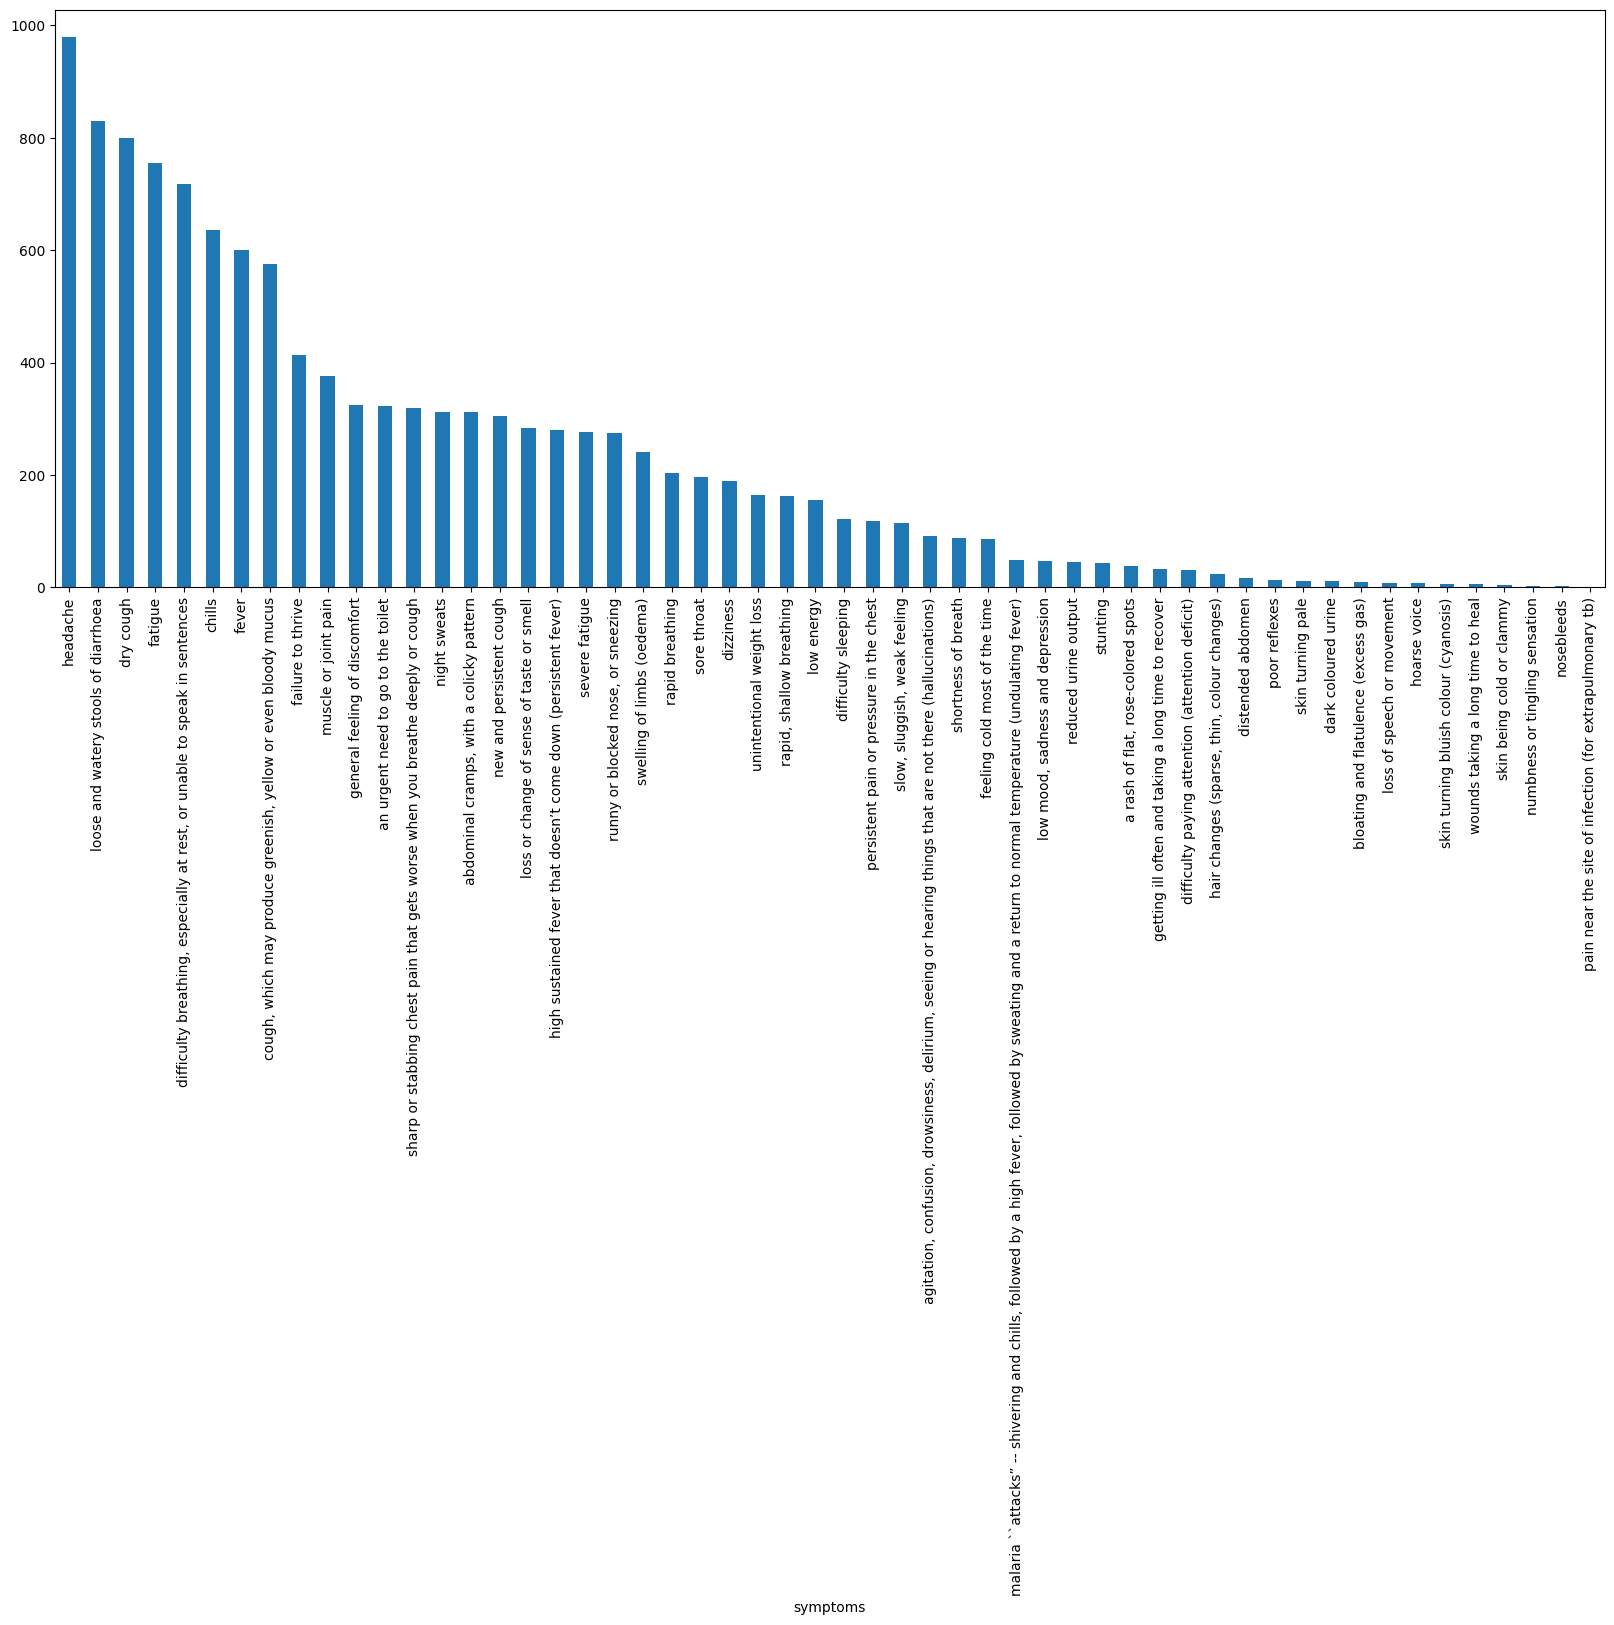

In [214]:
symptoms_by_id = df[["_uuid", "symptoms"]].drop_duplicates()
symptoms_by_id.symptoms.value_counts().plot(kind="bar", figsize=(20, 7.5))
symptoms_by_id.symptoms.value_counts().reset_index()

,count,mean,std,min,25%,50%,75%,max
age,3888.0,19.717958,21.117708,0.08,1.5,11.0,34.0,94.0


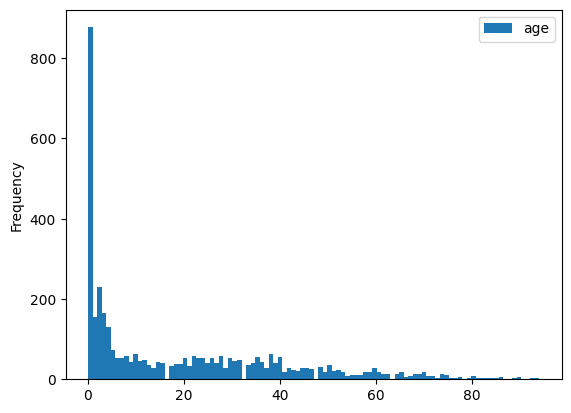

In [215]:
age_by_id = df[["_uuid", "age"]].drop_duplicates()
age_by_id.plot(kind="hist", bins=100)
age_by_id.describe().T

,count,mean,std,min,25%,50%,75%,max
height,2589.0,118.727572,45.327015,1.0,75.0,112.5,165.0,199.6


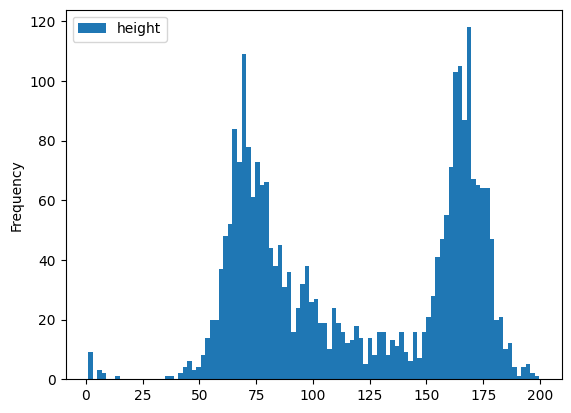

In [216]:
height_by_id = df[["_uuid", "height"]].drop_duplicates()
height_by_id.plot(kind="hist", bins=100)
height_by_id.describe().T

,count,mean,std,min,25%,50%,75%,max
weight,3040.0,30.470984,26.718259,0.6,8.0,15.0,56.0,166.0


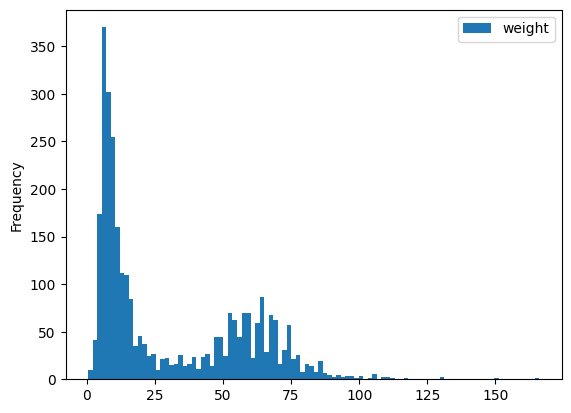

In [217]:
weight_by_id = df[["_uuid", "weight"]].drop_duplicates()
weight_by_id.plot(kind="hist", bins=100)
weight_by_id.describe().T

,count,mean,std,min,25%,50%,75%,max
bmi,2562.0,17.889745,5.866867,1.038781,13.714616,16.515683,21.543765,57.670127


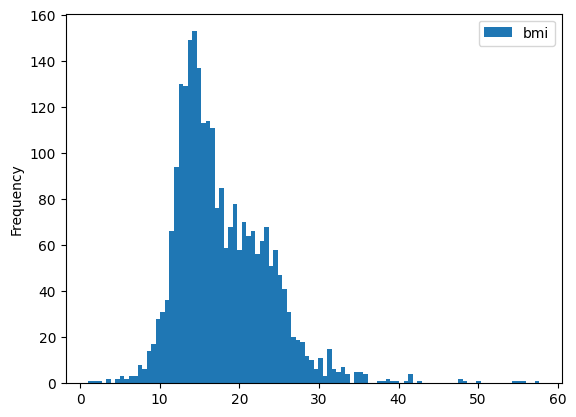

In [218]:
bmi_by_id = df[["_uuid", "bmi"]].drop_duplicates()
bmi_by_id.plot(kind="hist", bins=100)
bmi_by_id.describe().T

,count,mean,std,min,25%,50%,75%,max
temperature,3060.0,36.929703,1.035323,31.0,36.4,36.8,37.2,55.0


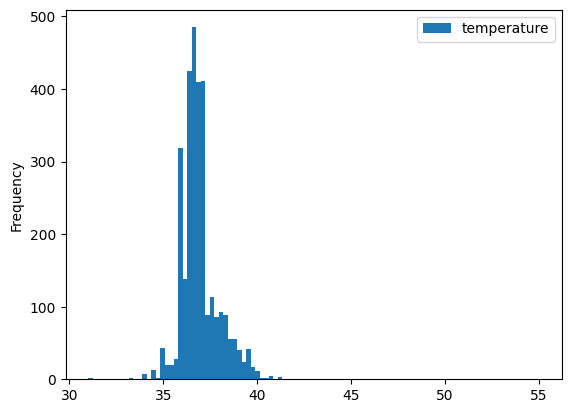

In [219]:
temperature_by_id = df[["_uuid", "temperature"]].drop_duplicates()
temperature_by_id.plot(kind="hist", bins=100)
temperature_by_id.describe().T

,count,mean,std,min,25%,50%,75%,max
spo2,1779.0,94.830242,7.774693,9.0,95.0,97.0,98.0,99.0


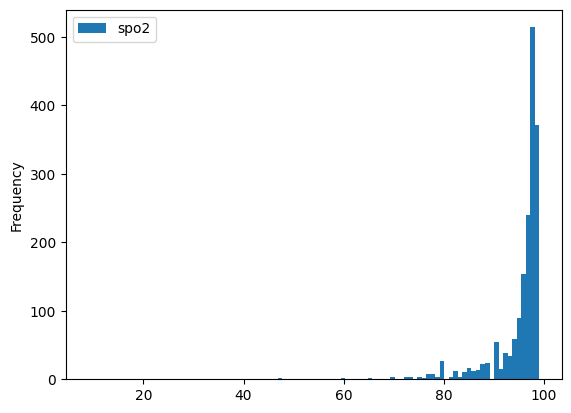

In [220]:
spo2_by_id = df[["_uuid", "spo2"]].drop_duplicates()
spo2_by_id.plot(kind="hist", bins=100)
spo2_by_id.describe().T

,count,mean,std,min,25%,50%,75%,max
bp_systolic,1011.0,116.288823,18.118085,70.0,104.0,116.0,127.0,183.0
bp_diastolic,1011.0,71.450049,12.182613,40.0,63.0,71.0,80.0,100.0


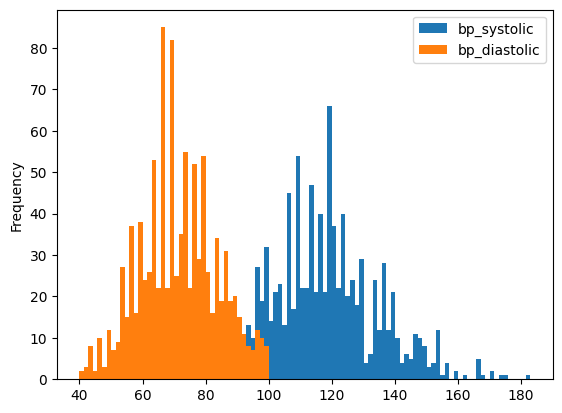

In [221]:
bp_by_id = df[["_uuid", "bp_systolic", "bp_diastolic"]].drop_duplicates()
bp_by_id.plot(kind="hist", bins=100)
bp_by_id.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,3474.0,6.936672,16.204602,1.0,2.0,3.0,7.0,365.0


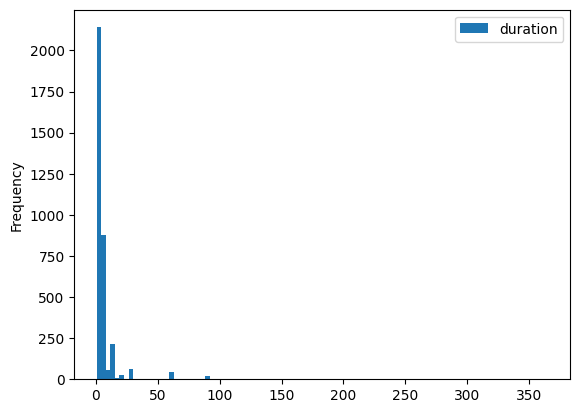

In [222]:
duration_by_id = df[["_uuid", "duration"]].drop_duplicates()
duration_by_id.plot(kind="hist", bins=100)
duration_by_id.describe().T

In [223]:
# df.dropna(subset="diagnosis", inplace=True)
# display(df.info())
# df

In [224]:
df_encoded = pd.concat([df, df["symptoms"].str.get_dummies()], axis=1)
df_encoded.drop(["symptoms", "nan"], axis=1, inplace=True)
df_encoded = pd.concat([df_encoded, df_encoded["diagnosis"]], axis=1)

# # If column is categorical, fill missing values with 0
# for col in df_encoded.columns:
#     if df_encoded[col].dtype.name == "category":
#         df_encoded[col] = df_encoded[col].cat.add_categories(0).fillna(0)

df_encoded = df_encoded.dropna(axis=0, how="all").dropna(axis=1, how="all")

df_encoded.to_csv('../data/interim/cdsa_encoded.csv', index=False)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173645 entries, 0 to 173644
Data columns (total 73 columns):
 #   Column                                                                                                                                            Non-Null Count   Dtype   
---  ------                                                                                                                                            --------------   -----   
 0   _uuid                                                                                                                                             173645 non-null  category
 1   patient_id                                                                                                                                        159393 non-null  category
 2   county                                                                                                                                            148269 non-null  category
 3  

In [225]:
for i, column in enumerate(df_encoded.columns):
    print('\t', i + 1, column.title())

	 1 _Uuid
	 2 Patient_Id
	 3 County
	 4 Age
	 5 Sex
	 6 Height
	 7 Weight
	 8 Bmi
	 9 Temperature
	 10 Bp_Systolic
	 11 Bp_Diastolic
	 12 Spo2
	 13 Muac
	 14 Duration
	 15 System
	 16 Lab_Investigation
	 17 Lab_Test
	 18 Diagnosis
	 19 A Rash Of Flat, Rose-Colored Spots
	 20 Abdominal Cramps, With A Colicky Pattern
	 21 Agitation, Confusion, Drowsiness, Delirium, Seeing Or Hearing Things That Are Not There (Hallucinations)
	 22 An Urgent Need To Go To The Toilet
	 23 Bloating And Flatulence (Excess Gas)
	 24 Chills
	 25 Cough, Which May Produce Greenish, Yellow Or Even Bloody Mucus
	 26 Dark Coloured Urine
	 27 Difficulty Breathing, Especially At Rest, Or Unable To Speak In Sentences
	 28 Difficulty Paying Attention (Attention Deficit)
	 29 Difficulty Sleeping
	 30 Distended Abdomen
	 31 Dizziness
	 32 Dry Cough
	 33 Failure To Thrive
	 34 Fatigue
	 35 Feeling Cold Most Of The Time
	 36 Fever
	 37 General Feeling Of Discomfort
	 38 Getting Ill Often And Taking A Long Time To Recover
	 